GCN


In [1]:
import os, glob, pandas, numpy, scipy, math, time, itertools
from sklearn import metrics, model_selection 
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


/home/yh221025/.pyenv/versions/anaconda3-2021.11/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yh221025/.pyenv/versions/anaconda3-2021.11/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.utils.smiles import from_smiles
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool


from torchinfo import summary
from torchvision.models import resnet18

torch.manual_seed(53)
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


1.12.0+cpu


In [3]:
from rdkit import rdBase, Chem, DataStructs
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Avalon import pyAvalonTools 
import cctk

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
from Function_241210 import Handle_OneHotEncoder, ShowROC, PlotHistory, OpenpyxlReadWorkbook, Handle_RocAucScore_AccuracyScore, Get_AutoSimilarities, LO_function_ForFingerprint


Py torch geometric 周辺のモデル・ハンドリング関数の読み込み

In [5]:
class PrepareGraph : 
    def __init__(self, *, ofp=None ) :
        try : 
            df = OpenpyxlReadWorkbook(ofp, IndexPos=0, ColumnPos=0).get('concat') 

        except : 
            print('pass at :',ofp)
        else : 
            # Nodes
            ps = df.loc[:,'smiles']
            ll = [[*LO_function_ForFingerprint(smi, LO=Chem.RDKFingerprint),v] for smi,v in df.loc[:,['smiles','amount']].values ]
            bm = [b for b,fp,v in ll]# To Drop Failed Smiles
            npa_NodeProp = numpy.hstack([
                numpy.array([fp for b,fp,v in ll if b]), 
                numpy.array([[v] for b,fp,v in ll if b]), 
            ])
                    
            # Auto Similarities # dge_Attrを用意する(完全グラフ)ため、全組合せ用意
            res = list()
            for LO in [
                # lambda m:AllChem.GetMorganFingerprintAsBitVect(m, 2,2048), 
                lambda m:AllChem.GetMACCSKeysFingerprint(m), 
                lambda m:pyAvalonTools.GetAvalonFP(m), 
                lambda m:Chem.RDKFingerprint(m), 
            ]: 
                df_sim = Get_AutoSimilarities(
                    ps[bm].reset_index(drop=True), 
                    LO_function_ForFingerprint = lambda smi:LO_function_ForFingerprint(smi, LO=LO), 
                    LO_function_ForSimilarity = DataStructs.BulkTanimotoSimilarity, 
                    GetPdistLike = False, 
                    DuplicateTriangleMatrix = False, 
                    UsePandas = True, 
                    Visualize = False, 
                )
                res.append(df_sim.stack())
            else : 
                df_pdl = pandas.concat(res, axis=1)
                npa_StackedPDist = df_pdl.values # numpy.stack(res, axis=-1)
                CombinationSet = [[i0,i1] for i0,i1 in df_pdl.index] # [[i0,i1] for (i0,i1),v in df_sim.stack().items() if v<0.5 ] 

        # "Prepare Graph" 2
        self.x          = npa_NodeProp                       # embeddings(NodeProperty)
        self.edge_index = numpy.array(CombinationSet).T      # edges(NodeIndexSet) # TRANSPOSE 必要
        self.edge_attr  = npa_StackedPDist                   # edge_attr(EdgeProperty)

    def Data(self) : 
        '''
        torch_geometric.data.Dataの形で出力する
        '''
        return Data(
            x           = torch.tensor(self.x).to(torch.float), 
            edge_index  = torch.tensor(self.edge_index).to(torch.long), 
            edge_attr   = torch.tensor(self.edge_attr).to(torch.float), 
        )


In [6]:
class GCN(torch.nn.Module):
    def __init__(self, in_node_dim, hidden_channels, fc_out_dim, *, sm_dim=None ):
        super().__init__()
        self.conv1 = GCNConv(in_node_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, math.prod(fc_out_dim))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch) 
        x0 = torch.reshape(self.fc(x), (-1,*fc_out_dim)) # stack (re-flatten)
        x1 = F.softmax(x0, dim=sm_dim) # 反転付きのOne-Hot => dim=softmax_dim
        x2 = F.log_softmax(x0, dim=sm_dim) # Multilabel Classification
        return x0, x1, x2

class GAT(torch.nn.Module):
    def __init__(self, in_node_dim, hidden_channels, fc_out_dim, *, sm_dim=None ):
        super().__init__()
        self.conv1 = GATConv(in_node_dim, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, math.prod(fc_out_dim))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch) 
        x0 = torch.reshape(self.fc(x), (-1,*fc_out_dim)) # stack (re-flatten)
        x1 = F.softmax(x0, dim=sm_dim) # 反転付きのOne-Hot => dim=softmax_dim
        x2 = F.log_softmax(x0, dim=sm_dim) # Multilabel Classification
        return x0, x1, x2


class Dataset_FromListedData(Dataset):
    '''
    datas : List化されたtorch_geometric.data.Dataの形であることが必要、torch_geometric.data.Data内への目的変数yの事後組込が必要
    '''
    def __init__(self, datas):
        super().__init__()
        self.datas = datas # list of torch_geometric.data.Data

    def len(self):
        return len(self.datas)

    def get(self, idx):
        data = self.datas[idx]
        
        return data


データロード


219 / 221


,Aerial part,Bulb,Dried material,Flowers,Fruit,Herb,Leaf,Leaf and flower,Rhizome,Root,Seed,Shoot,Stem,Whole plant,Wood
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
215,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
216,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
217,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


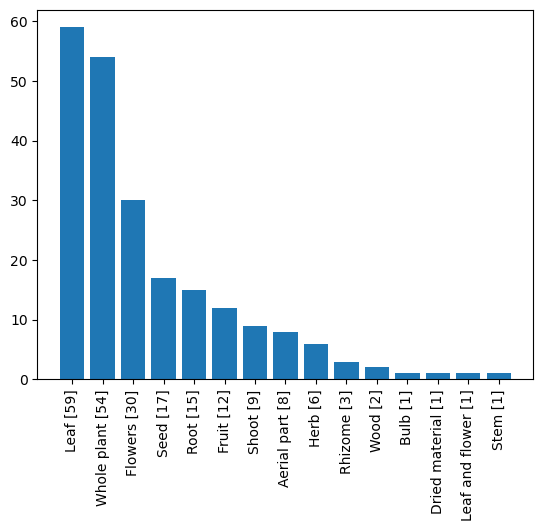

shapes : 219 9 219 (9,) 219 (9,)


In [7]:
# データロード
cwd = os.getcwd()
NotUseFiles = [
    os.path.join(cwd, 'datalink', 'CRESOL.240929', 'CRESOL178.xlsx'), # CRESOL178
    os.path.join(cwd, 'datalink', 'CRESOL.240929', 'CRESOL9.xlsx'), # CRESOL9
]


# CRESOL Files(xlsx)
wdir, ext = os.path.join(cwd, 'datalink', "CRESOL.240929"), '.xlsx'
d_CRESOL = dict((os.path.basename(p).strip(ext),p) for p in glob.glob(os.path.join(wdir,'*')) if p.endswith(ext))


# Main File(CSIR CIMAP AROMA  Essential Oil.xlsx)
ofp = os.path.join(cwd, 'datalink', "CSIR CIMAP AROMA  Essential Oil.xlsx")
df = OpenpyxlReadWorkbook(ofp, IndexPos=0, ColumnPos=0).get('table0')
ps_ofp = df.loc[:,"('Details [href]', 1)"].map(lambda crid:d_CRESOL.get(crid))
bm = ps_ofp.map(lambda ofp : not(ofp in NotUseFiles) )
print(sum(bm), '/', len(bm))


TargetNames = [
    'Aerial part',
    # 'Bulb',
    # 'Dried material',
    'Flowers',
    'Fruit',
    'Herb',
    'Leaf',
    # 'Leaf and flower',
    # 'Rhizome',
    'Root',
    'Seed',
    'Shoot',
    # 'Stem',
    'Whole plant',
    # 'Wood',
]


# Target variables ; One-Hot
cl = Handle_OneHotEncoder()
out = cl.fittransform(df[bm].loc[:,'Plant Tissue Name'].values.reshape(-1, 1)).out() # 通常のOne-Hot
display(out.df_1H)


# countplot
ps = out.df_1H.sum().sort_values(ascending=False)
plt.figure()
plt.bar(list(x[0]+' ['+str(v)+']' for x,v in ps.items()), list(x for x in ps.values))
plt.xticks(rotation=90)
plt.show()


# データ準備
xs = list(x for x in ps_ofp[bm].values) # [0:100] # df.loc[:,'FilePath.SplitBySerialNo']
# ys = list(numpy.stack([ar,numpy.logical_not(ar)], axis=1).T for ar in out.df_1H.loc[:,TargetNames].astype(bool).values) # [0:100] # AddInverse # Collate Stack OK 最終的にはこの目的変数を使用する
ys = list(ar for ar in out.df_1H.loc[:,TargetNames].astype(bool).values) # [0:100] # nn.BCEWithLogitsLoss()用 # ar.reshape(*ar.shape,1)
ylbs = list(ar for ar in out.df_1H.loc[:,TargetNames].astype(bool).values) # [0:100] # Listed numpy array of Label-set
print('shapes :', len(xs),len(TargetNames),len(ys),ys[0].shape, len(ylbs),ylbs[0].shape )


In [8]:
%%time
# 繰り返し処理でList化されたtorch_geometric.data.Dataを準備

datas = list()
for ofp,y,ylb in zip(xs, ys, ylbs) : 
    data = PrepareGraph(ofp=ofp).Data()
    data.y = torch.reshape(torch.tensor(y, dtype=torch.float), (-1,*y.shape)) 
    data.ylb = torch.reshape(torch.tensor(ylb, dtype=torch.long), (-1,*ylb.shape)) 
    datas.append(data)


CPU times: user 1min 33s, sys: 109 ms, total: 1min 33s
Wall time: 34.1 s


学習（CVからの各AUC評価）

In [9]:
# Params
device = 'cpu'
sm_dim = 1
batch_size=32
MaxEpoch=61 # max_epoch
thr = 0.5 # For Use P-Proba (BCEWithLogitsLoss)


# Prepare CV set 
n_splits=5
shuffle=True
random_state=16

kf = model_selection.KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state) 


2049 64 (9,)
0
Epoch: 0 	 Train 	Loss: 0.438 	 Val   	Loss: 0.348
Epoch: 3 	 Train 	Loss: 0.252 	 Val   	Loss: 0.324
Epoch: 10 	 Train 	Loss: 0.199 	 Val   	Loss: 0.352
Epoch: 30 	 Train 	Loss: 0.082 	 Val   	Loss: 0.362
Epoch: 60 	 Train 	Loss: 0.077 	 Val   	Loss: 0.530
Loss vs epochs


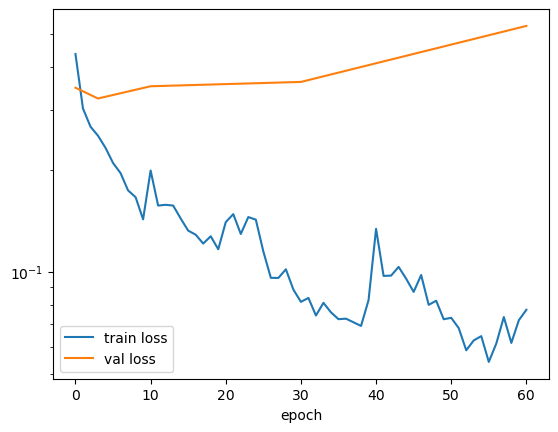

2049 64 (9,)
1
Epoch: 0 	 Train 	Loss: 0.447 	 Val   	Loss: 0.356
Epoch: 3 	 Train 	Loss: 0.269 	 Val   	Loss: 0.313
Epoch: 10 	 Train 	Loss: 0.211 	 Val   	Loss: 0.309
Epoch: 30 	 Train 	Loss: 0.116 	 Val   	Loss: 0.449
Epoch: 60 	 Train 	Loss: 0.086 	 Val   	Loss: 0.618
Loss vs epochs


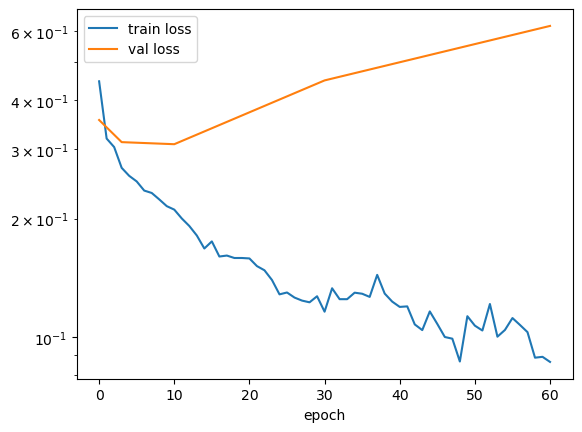

2049 64 (9,)
2
Epoch: 0 	 Train 	Loss: 0.467 	 Val   	Loss: 0.319
Epoch: 3 	 Train 	Loss: 0.296 	 Val   	Loss: 0.313
Epoch: 10 	 Train 	Loss: 0.285 	 Val   	Loss: 0.275
Epoch: 30 	 Train 	Loss: 0.163 	 Val   	Loss: 0.263
Epoch: 60 	 Train 	Loss: 0.146 	 Val   	Loss: 0.371
Loss vs epochs


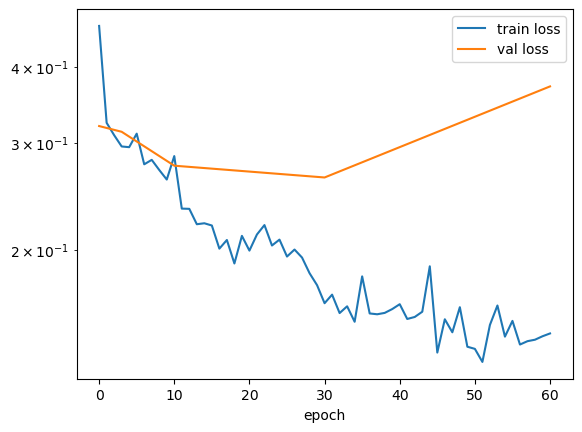

2049 64 (9,)
3
Epoch: 0 	 Train 	Loss: 0.417 	 Val   	Loss: 0.329
Epoch: 3 	 Train 	Loss: 0.267 	 Val   	Loss: 0.328
Epoch: 10 	 Train 	Loss: 0.213 	 Val   	Loss: 0.297
Epoch: 30 	 Train 	Loss: 0.136 	 Val   	Loss: 0.338
Epoch: 60 	 Train 	Loss: 0.107 	 Val   	Loss: 0.558
Loss vs epochs


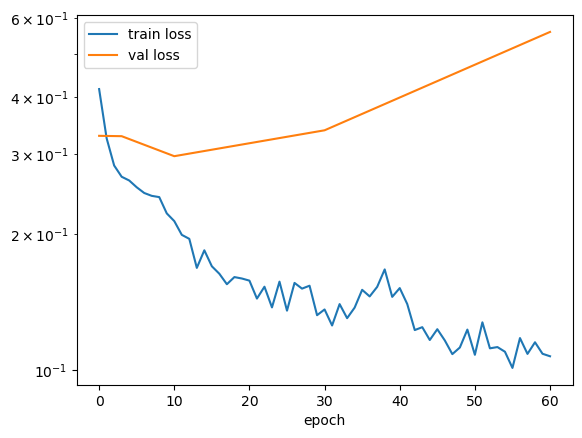

2049 64 (9,)
4
Epoch: 0 	 Train 	Loss: 0.429 	 Val   	Loss: 0.294
Epoch: 3 	 Train 	Loss: 0.268 	 Val   	Loss: 0.298
Epoch: 10 	 Train 	Loss: 0.166 	 Val   	Loss: 0.350
Epoch: 30 	 Train 	Loss: 0.093 	 Val   	Loss: 0.625
Epoch: 60 	 Train 	Loss: 0.068 	 Val   	Loss: 1.076
Loss vs epochs


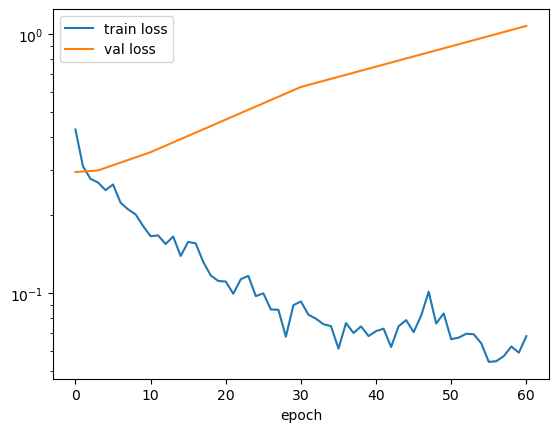

CPU times: user 31min 26s, sys: 19 s, total: 31min 45s
Wall time: 1min 35s


In [10]:
%%time
# Run => Train / Val  => Result

ValidationResult = list()
for cvno, (train_index, test_index) in enumerate(kf.split(datas, ys)):
    
    # Train/Testデータセットとデータローダーの作成
    data_train = [datas[i] for i in train_index]
    dataset = Dataset_FromListedData(data_train)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    data_test = [datas[i] for i in test_index]
    test_dataset = Dataset_FromListedData(data_test)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    
    in_node_dim, hidden_channels, fc_out_dim = dataset[0].num_node_features, 64, tuple(dataset[0].y.shape[1:])
    print(in_node_dim, hidden_channels, fc_out_dim )


    model = GAT(in_node_dim, hidden_channels, fc_out_dim ) 
    model = model.to(device)
    
    
    # 最適化手法
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
    # optimizer = torch.optim.Adadelta(model.parameters(), lr=0.25, rho=0.95) # lr=learning_rate
    
    criterion = nn.BCEWithLogitsLoss() 
    # criterion=torch.nn.functional.nll_loss 
    # criterion=torch.nn.BCELoss()
    # criterion=nn.CrossEntropyLoss() # use for original CNN-NLP
    
    
    print(cvno)
    train_loss = []
    val_loss = []
    for epoch in range(MaxEpoch):
        loss_local = 0 # ; accu_local = [] # reset
    
        # train 
        model.train()
        for batch in dataloader:
            optimizer.zero_grad()
            batch = batch.to(device)
            out,out_sig,out_lsm = model(batch) # 伝搬
            loss = criterion(out, batch.y) #loss計算 # nn.BCEWithLogitsLoss 用
            # loss = criterion(out_lsm, batch.ylb) #loss計算 # Log_SoftMax + OneHotTarget + nll_loss 専用
            # loss = criterion(out_sig, batch.y) #loss計算 # https://qiita.com/Mony0_S/items/2d87918e0fdc77ccecb5
            loss.backward()
            optimizer.step()
            loss_local += loss.item()
        train_loss.append((epoch, loss_local/len(dataloader)))
        
    
        # val
        if epoch in [0,3,10,30,100,300,1000,MaxEpoch-1] : 
            alabel_local = [] # alabel
            plabel_local = [] # plabel
            pproba_local = [] # pproba
            
            model.eval() #推論モード
            loss_local = 0
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = batch.to(device)
                    out,out_sig,out_lsm = model(batch) # 伝搬
                    loss = criterion(out, batch.y) #loss計算 # nn.BCEWithLogitsLoss 用
                    # loss = criterion(out_lsm, batch.ylb) #loss計算 # Log_SoftMax + OneHotTarget + nll_loss 用
                    # loss = criterion(out_sig, batch.y) #loss計算 # https://qiita.com/Mony0_S/items/2d87918e0fdc77ccecb5
                    loss_local += loss.item()
                    
                    alabel_local.append(batch.ylb) # alabel 
                    # # LSM ver
                    # plabel_local.append(torch.argmax(out_lsm.data, dim=sm_dim)) # plabel 
                    # pproba_local.append(torch.exp(out_lsm)[:,1,:].numpy()) # pproba 
                    # BCE_logit ver
                    plabel_local.append(torch.sigmoid(out).numpy() > thr ) # plabel 
                    pproba_local.append(torch.sigmoid(out).numpy() ) # pproba 
                    
                else : 
                    val_loss.append((epoch, loss_local / len(test_dataloader))) 
                    ValidationResult.append([
                        cvno, 
                        epoch, 
                        numpy.vstack(alabel_local), # all_labels 
                        numpy.vstack(pproba_local), # all_pproba 
                        numpy.vstack(plabel_local), # y_pred 
                    ])
    
            print(
                'Epoch: {}'.format(epoch), '\t', 
                'Train \tLoss: {:.3f}'.format(train_loss[-1][1]), '\t', 
                'Val   \tLoss: {:.3f}'.format(val_loss[-1][1]), 
            )
    else : 
        PlotHistory(
            train_loss = list(l for e,l in train_loss), 
            val_loss = list(l for e,l in val_loss), 
            train_epochs = list(e for e,l in train_loss), 
            val_epochs = list(e for e,l in val_loss), 
        )


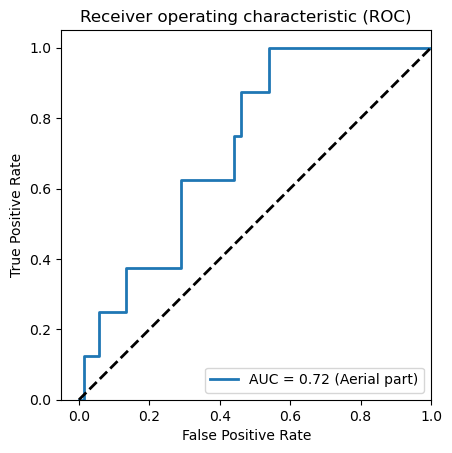

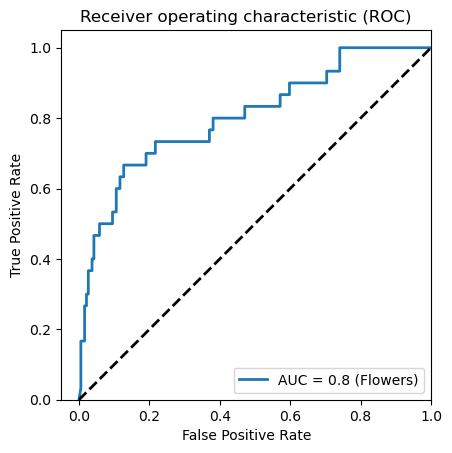

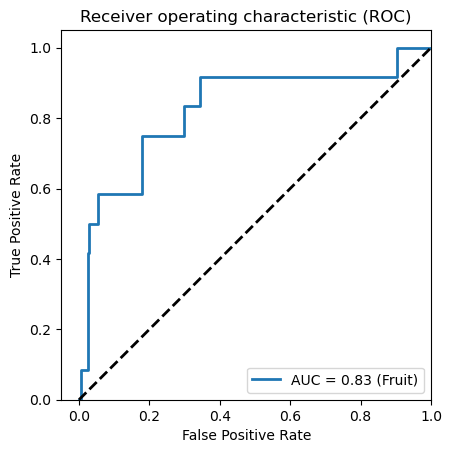

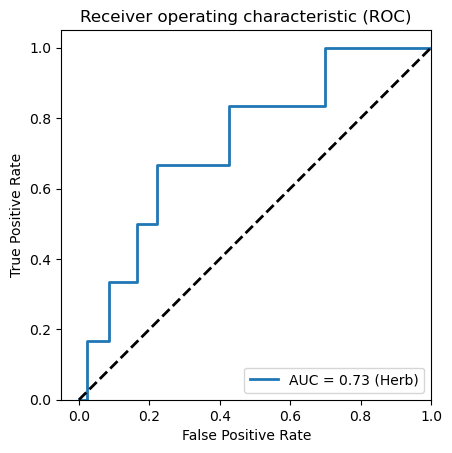

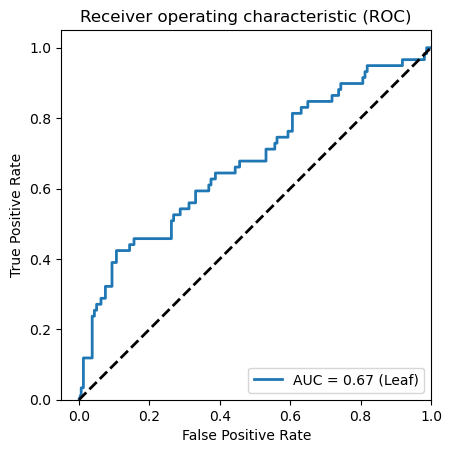

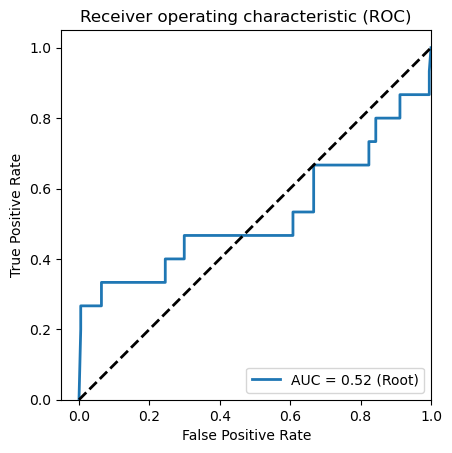

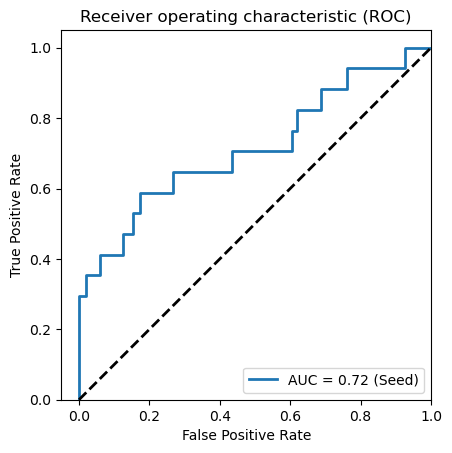

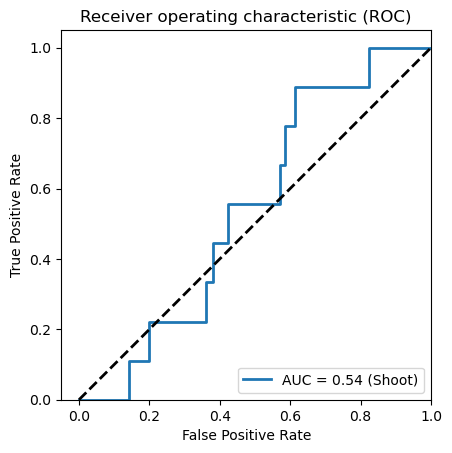

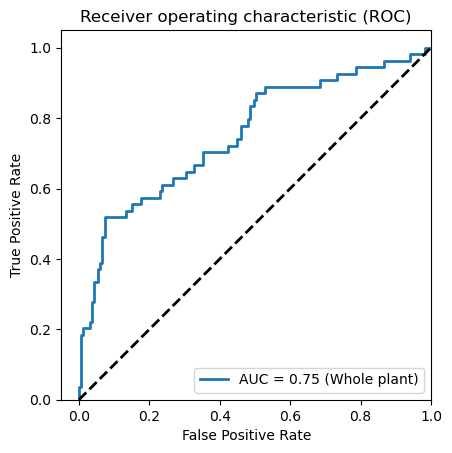

In [11]:
# CVSet越しのnumpy.vstackあり

epoch
TargetNames = TargetNames # cn_t0
res = list()
for epoch,dfp in pandas.DataFrame(ValidationResult).groupby(1) : 
    if epoch ==60 : 
        ShowROC_InLine=True
    else : 
        ShowROC_InLine=False
        
    stacked_all_labels = numpy.vstack(dfp.loc[:,2].values)
    stacked_all_pproba = numpy.vstack(dfp.loc[:,3].values)
    for tl,pp,lb in zip(stacked_all_labels.T, stacked_all_pproba.T, TargetNames) : 
        res.append(((epoch,lb),Handle_RocAucScore_AccuracyScore(tl, pp, ShowROC_InLine=ShowROC_InLine, comment=lb)))
else : 
    df_ValidationResult = pandas.DataFrame(dict(res)).T
    df_AUC_History = df_ValidationResult.loc[:,'auc'].unstack().T


In [12]:
df_AUC_History

,0,3,10,30,60
Aerial part,0.527844,0.656991,0.683057,0.854858,0.722156
Flowers,0.588360,0.686949,0.782363,0.776631,0.804674
Fruit,0.627214,0.662238,0.814815,0.854267,0.826087
Herb,0.630673,0.491393,0.692488,0.654147,0.730047
Leaf,0.460064,0.562606,0.641843,0.694597,0.673252
Root,0.554248,0.581699,0.588562,0.621242,0.524510
Seed,0.481654,0.412638,0.622306,0.698893,0.715783
Shoot,0.456085,0.458730,0.456614,0.523810,0.543915
Whole plant,0.541863,0.660718,0.646352,0.717396,0.754209


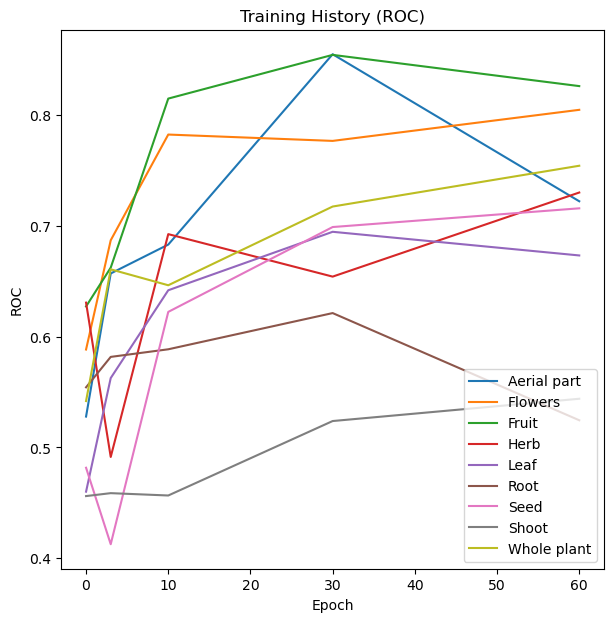

In [13]:
# df_AUC_History可視化

fig = plt.figure(figsize=(7,7)) #...1
for i in df_AUC_History.index : 
    ps = df_AUC_History.loc[i,:]
    plt.plot(
        [c for c,v in ps.items()], 
        [v for c,v in ps.items()], 
        label=i, 
    )
else : 
    # # plt.xlim([-0.05, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('Epoch')
    plt.ylabel('ROC')
    plt.title('Training History (ROC)')
    plt.legend(loc="lower right")
    # plt.gca().set_aspect('equal', adjustable='box') # https://qiita.com/show2214/items/064c671709dda08d78c8
plt.show()


In [14]:
summary(model)

Layer (type:depth-idx)                   Param #
GAT                                      --
├─GATConv: 1-1                           192
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       131,136
│    └─Linear: 2-3                       (recursive)
├─GATConv: 1-2                           192
│    └─SumAggregation: 2-4               --
│    └─Linear: 2-5                       4,096
│    └─Linear: 2-6                       (recursive)
├─Linear: 1-3                            585
Total params: 136,201
Trainable params: 136,201
Non-trainable params: 0

In [15]:
ここで停止

NameError: name 'ここで停止' is not defined